# _Set Up_

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
# fastai libraries
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import EarlyStoppingCallback

In [8]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os
from pathlib import Path

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [9]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

# _Load in Data_

In [47]:
from test_folder import replicate

sample_df = replicate.load_data(path, 1, percent=0.1);

Added valid column
------------------------------
Extracted Patient ID from Path column and created new column named Patient_id
------------------------------
Concatenated train_df and valid_df.
------------------------------
Created function named seed_data to set seed for sample data
------------------------------
Seeded data.
------------------------------
Created sample dataframe with input seed and 10.0% of original data
------------------------------


In [48]:
sample_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,Patient_id
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003
11,CheXpert-v1.0-small/train/patient00006/study1/...,Female,42,Frontal,AP,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,patient00006
44,CheXpert-v1.0-small/train/patient00015/study1/...,Female,76,Frontal,AP,NaN,NaN,NaN,1.0,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,False,patient00015
45,CheXpert-v1.0-small/train/patient00015/study2/...,Female,76,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,1.0,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,False,patient00015
91,CheXpert-v1.0-small/train/patient00027/study1/...,Male,56,Frontal,PA,NaN,0.0,NaN,1.0,NaN,NaN,0.0,NaN,1.0,0.0,0.0,NaN,NaN,NaN,False,patient00027


In [49]:
sample_df.shape

(22571, 21)

In [50]:
sample_df = replicate.dl_dataframe_setup(sample_df, 'Cardiomegaly');

Created data set with expressed competition pathology, replacing NaN's with 0 and resetting the index
------------------------------

Cardiomegaly
------------------------------
Shape of sample_df: (22571, 3)


In [51]:
sample_df.head()

,Path,valid,Cardiomegaly
0,CheXpert-v1.0-small/train/patient00003/study1/...,False,0.0
1,CheXpert-v1.0-small/train/patient00006/study1/...,False,0.0
2,CheXpert-v1.0-small/train/patient00015/study1/...,False,0.0
3,CheXpert-v1.0-small/train/patient00015/study2/...,False,0.0
4,CheXpert-v1.0-small/train/patient00027/study1/...,False,0.0


In [52]:
valid_obs = sample_df[sample_df['valid'] == True]

valid_obs.shape

(234, 3)

In [53]:
valid_obs['Cardiomegaly'].value_counts()

0.0    166
1.0     68
Name: Cardiomegaly, dtype: int64

In [54]:
sample_df['Cardiomegaly'].value_counts()

 0.0    19074
 1.0     2666
-1.0      831
Name: Cardiomegaly, dtype: int64

In [55]:
sample_df = replicate.uignore(sample_df, 'Cardiomegaly');

Dropped -1 observations.
------------------------------
Converted pathology column into integer type.
------------------------------


In [56]:
sample_df.head()

,Path,valid,Cardiomegaly
0,CheXpert-v1.0-small/train/patient00003/study1/...,False,0
1,CheXpert-v1.0-small/train/patient00006/study1/...,False,0
2,CheXpert-v1.0-small/train/patient00015/study1/...,False,0
3,CheXpert-v1.0-small/train/patient00015/study2/...,False,0
4,CheXpert-v1.0-small/train/patient00027/study1/...,False,0


In [57]:
sample_df['Cardiomegaly'].value_counts()

0    19074
1     2666
Name: Cardiomegaly, dtype: int64

# _Set Up for Deep Learning_

In [58]:
src = replicate.get_src(sample_df, path, 'Cardiomegaly');

In [59]:
data = replicate.get_data(64, src)

using bs=16, have 7024MB of GPU RAM free.
------------------------------
Data ready.


In [60]:
data

ImageDataBunch;

Train: LabelList (21506 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

# _Set Up DL Model_

In [61]:
# create a pretrained densenet121 cnn_learner with error rate and AUROC as the metrics with a ps of 0.5 (i.e. 50% of randomly selected neurons will be ignored from the n-1 layer) and batch normalization
learn = cnn_learner(data=data, base_arch=models.densenet121, metrics=[error_rate, AUROC()], pretrained=True,
                     ps=0.5, bn_final=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.16E-01
Min loss divided by 10: 1.00E-01


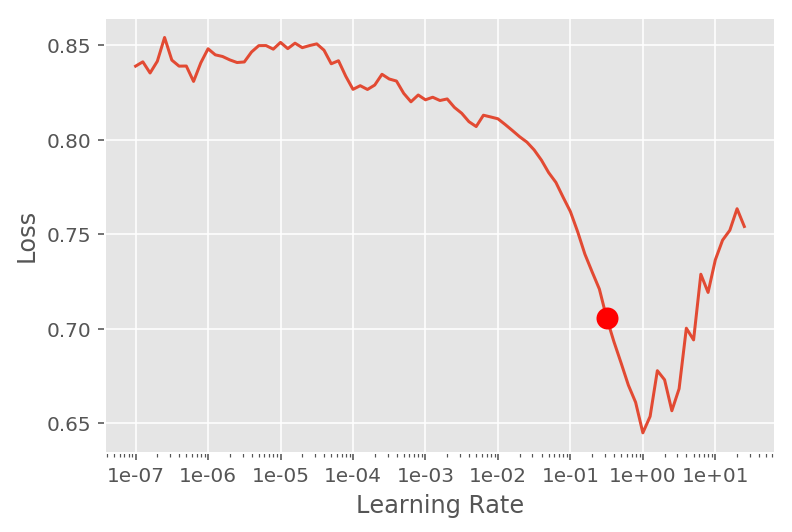

In [62]:
from test_folder import deeplearning

deeplearning.lr_finder_plot(learn)

In [63]:
lr = learn.recorder.min_grad_lr
lr

0.31622776601683794

In [64]:
# check the loss function
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

# _First Round of Training_

In [65]:
learn.fit_one_cycle(5, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=3)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.360813,0.868705,0.294872,0.393958,02:47
1,0.385992,0.730642,0.290598,0.500532,02:47
2,0.387132,0.654144,0.286325,0.381999,02:48
3,0.370070,0.639091,0.290598,0.732193,02:49
4,0.316876,0.682423,0.290598,0.710844,02:47


In [66]:
learn.save('trial19-rd1')

# _New Data (50% of CheXpert)_

In [83]:
# load data
sample_df2 = replicate.load_data(path, 2, percent=0.5);

Added valid column
------------------------------
Extracted Patient ID from Path column and created new column named Patient_id
------------------------------
Concatenated train_df and valid_df, resulting shape = (223648, 21)
------------------------------
Created function named seed_data to set seed for sample data
------------------------------
Seeded data.
------------------------------
Created sample dataframe with input seed and 50.0% of original data
Resulting sample df has shape of (110968, 21)
------------------------------


In [84]:
# set in appropriate formate for DL
sample_df2 = replicate.dl_dataframe_setup(sample_df2, 'Cardiomegaly');

Created data set with expressed competition pathology, replacing NaN's with 0 and resetting the index
------------------------------

Cardiomegaly
------------------------------
Shape of sample_df: (110968, 3)


In [86]:
# drop uncertain labels
sample_df2 = replicate.uignore(sample_df2, 'Cardiomegaly');

Dropped -1 observations.
------------------------------
Converted pathology column into integer type.
------------------------------
Shape of new dataframe: (106980, 3)


# _DL Set-up For New Data_

In [87]:
src2 = replicate.get_src(sample_df2, path, 'Cardiomegaly');
data2 = replicate.get_data(64, src2)

using bs=16, have 6968MB of GPU RAM free.
------------------------------
Data ready.


In [88]:
data2

ImageDataBunch;

Train: LabelList (106746 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

In [89]:
learn.data = data2

# _Second Round of Training_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.26E-07
Min loss divided by 10: 2.00E-06


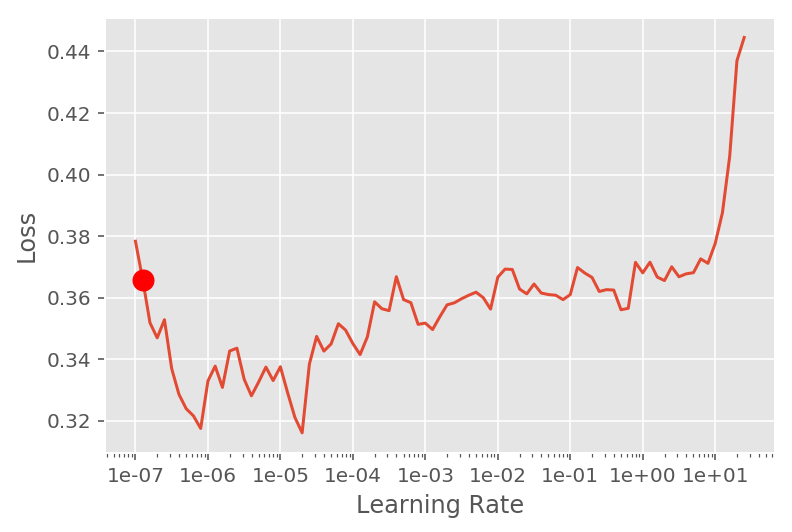

In [90]:
# unfreeze all layers then find appropriate learning rate
learn.freeze()

deeplearning.lr_finder_plot(learn)

In [91]:
lr = learn.recorder.min_grad_lr
lr

1.2589254117941672e-07

In [72]:
# load the previous weights
#learn.load('trial19-rd1');

In [92]:
# train model
learn.fit_one_cycle(5, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.342609,0.689090,0.290598,0.704288,14:08
1,0.354245,0.669606,0.290598,0.711198,14:02
2,0.357791,0.682066,0.290598,0.709249,14:01


Epoch 3: early stopping


In [93]:
learn.save('trial19-rd2')